In [68]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [69]:
# Load dataset
# data can be derived from https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification 
train_dataset = tf.data.Dataset.load('train') 
val_dataset   = tf.data.Dataset.load('val')

In [70]:
# pre-batch dataset beforehand
batch_size = 128
train_dataset_batch = train_dataset.batch(batch_size)
val_dataset_batch =val_dataset.batch(batch_size)

## Parallel CNN

In [63]:
def CNN():
    input_data=tf.keras.Input(shape=(80, 80, 1))
    
    # First branch
    b1_1=layers.Conv2D(filters=3,kernel_size=8,padding="same",activation=layers.LeakyReLU(alpha=0.3))(input_data)
    b1_2=layers.MaxPool2D(pool_size=4)(b1_1)
    b1_3=layers.Flatten()(b1_2)
    
    # Second branch
    b2_1=layers.Conv2D(filters=4,kernel_size=4,padding="same",activation=layers.LeakyReLU(alpha=0.3))(input_data)
    b2_2=layers.MaxPool2D(pool_size=2)(b2_1)
    b2_3=layers.Flatten()(b2_2)
    
    # Merging branch
    branch_concatenate=layers.Concatenate()([b1_3,b2_3])
    output=layers.Dense(8,activation='softmax')(branch_concatenate) #softmax act. to ensure outcome between 0-1
    
    # Compile model
    model = tf.keras.models.Model(input_data, output)
    sgd = tf.keras.optimizers.SGD(5e-3)
    model.compile(optimizer=sgd, loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
    return model

In [64]:
CNN().summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 80, 80, 3)    195         ['input_29[0][0]']               
                                                                                                  
 conv2d_43 (Conv2D)             (None, 80, 80, 4)    68          ['input_29[0][0]']               
                                                                                                  
 max_pooling2d_42 (MaxPooling2D  (None, 20, 20, 3)   0           ['conv2d_42[0][0]']              
 )                                                                                         

Epoch 1/50
75/75 [==============================] - 9s 120ms/step - loss: 1.4916 - accuracy: 0.4565 - val_loss: 1.2982 - val_accuracy: 0.5121
Epoch 2/50
75/75 [==============================] - 9s 121ms/step - loss: 1.1897 - accuracy: 0.5623 - val_loss: 1.1717 - val_accuracy: 0.5542
Epoch 3/50
75/75 [==============================] - 10s 131ms/step - loss: 1.0837 - accuracy: 0.5987 - val_loss: 1.1080 - val_accuracy: 0.5833
Epoch 4/50
75/75 [==============================] - 10s 130ms/step - loss: 1.0166 - accuracy: 0.6259 - val_loss: 1.0642 - val_accuracy: 0.6017
Epoch 5/50
75/75 [==============================] - 9s 124ms/step - loss: 0.9650 - accuracy: 0.6449 - val_loss: 1.0300 - val_accuracy: 0.6208
Epoch 6/50
75/75 [==============================] - 9s 126ms/step - loss: 0.9217 - accuracy: 0.6646 - val_loss: 1.0012 - val_accuracy: 0.6321
Epoch 7/50
75/75 [==============================] - 9s 125ms/step - loss: 0.8836 - accuracy: 0.6787 - val_loss: 0.9758 - val_accuracy: 0.6463
Epoc

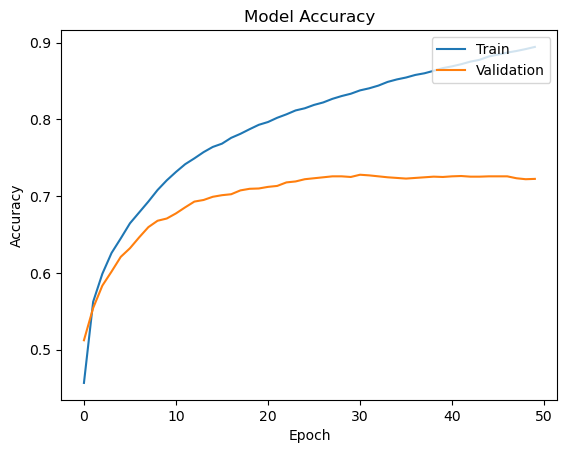

Final validation accuracy 0.7225000262260437
Maximal validation accuracy achieved = 0.7279166579246521 at epoch 31


In [65]:
model=CNN()
history=model.fit(x=train_dataset_batch,epochs=50,verbose=1,validation_data=val_dataset_batch)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print(f"Final validation accuracy", history.history['val_accuracy'][-1])
print(f"Maximal validation accuracy achieved =", np.max(history.history['val_accuracy']), 
      "at epoch",(np.argmax(history.history['val_accuracy'])+1))

As can be seen in the graph, the model attains over $70\%$ out-of-sample accuracy but remain below $73\%$ even for different learning rates. Setting the learning rate equal to `5e-3` might look really specific but avoids that the model overfits too early, diverges or converges too slow given that number of epochs is fixed at `50`. For instance, a learning rate of `1e-2` reaches $72\%$ quite early but starts overfitting towards the later epochs, whereas `learning_rate=1e-3` barely reach $68\%$ accuracy.

Note that the model uses `loss=keras.losses.CategoricalCrossentropy()` since the output is a $8\times 1$ vector with one 1 and seven 0's. The learning rate is set to `1e-2` to restrict early overfitting and ensure consistent results. 

## CNN-RNN

In [23]:
def reduce_dimension(x, y):
    return tf.squeeze(x, axis=-1), y

train_dataset_squeeze = train_dataset.map(reduce_dimension)
val_dataset_squeeze = val_dataset.map(reduce_dimension)

In [24]:
train_dataset_batch_1 = train_dataset_squeeze.batch(batch_size)
val_dataset_batch_1 = val_dataset_squeeze.batch(batch_size)

In [31]:
def CNN_RNN():
    input_data=tf.keras.Input(shape=(80, 80)) #reduced input shape due to squeezed dataset
    x = layers.Conv1D(filters=8,kernel_size=4,activation=layers.LeakyReLU(alpha=0.3))(input_data)
    x = layers.MaxPool1D(pool_size=2)(x)
    x = layers.Conv1D(filters=6,kernel_size=3,activation=layers.LeakyReLU(alpha=0.3))(x)
    x = layers.MaxPool1D(pool_size=2)(x)
    x = layers.LSTM(units=128, return_sequences=True)(x)
    x = layers.LSTM(units=32, return_sequences=False)(x)
    x = layers.Dense(200, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(8, activation="softmax")(x)
    
    model = tf.keras.models.Model(input_data, x)
    sgd = tf.keras.optimizers.SGD(1e-1)
    model.compile(optimizer=sgd, loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
    return model

In [32]:
CNN_RNN().summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 80, 80)]          0         
                                                                 
 conv1d_10 (Conv1D)          (None, 77, 8)             2568      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 38, 8)            0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 36, 6)             150       
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 18, 6)            0         
 g1D)                                                            
                                                                 
 lstm_10 (LSTM)              (None, 18, 128)           691

Epoch 1/50
75/75 [==============================] - 4s 35ms/step - loss: 1.9174 - accuracy: 0.2514 - val_loss: 1.8147 - val_accuracy: 0.2879
Epoch 2/50
75/75 [==============================] - 2s 29ms/step - loss: 1.7504 - accuracy: 0.3204 - val_loss: 1.7264 - val_accuracy: 0.3279
Epoch 3/50
75/75 [==============================] - 2s 31ms/step - loss: 1.6935 - accuracy: 0.3531 - val_loss: 1.6464 - val_accuracy: 0.3642
Epoch 4/50
75/75 [==============================] - 2s 31ms/step - loss: 1.6263 - accuracy: 0.3911 - val_loss: 1.5531 - val_accuracy: 0.4187
Epoch 5/50
75/75 [==============================] - 2s 30ms/step - loss: 1.4960 - accuracy: 0.4380 - val_loss: 1.4169 - val_accuracy: 0.4521
Epoch 6/50
75/75 [==============================] - 2s 29ms/step - loss: 1.4096 - accuracy: 0.4668 - val_loss: 1.3596 - val_accuracy: 0.4700
Epoch 7/50
75/75 [==============================] - 2s 30ms/step - loss: 1.3469 - accuracy: 0.4859 - val_loss: 1.3603 - val_accuracy: 0.4771
Epoch 8/50
75

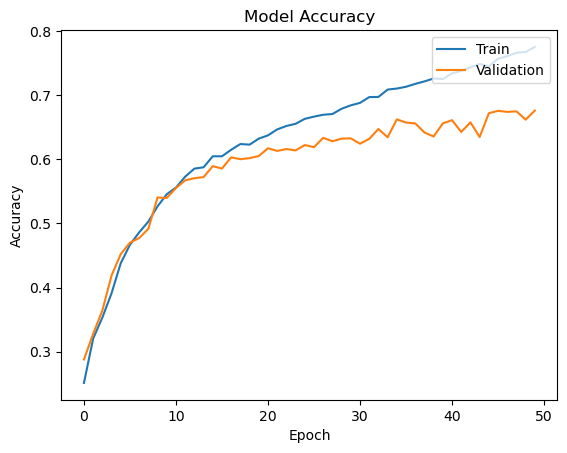

Final validation accuracy 0.6758333444595337
Maximal validation accuracy achieved over 50 epochs = 0.6758333444595337


In [33]:
model = CNN_RNN()
history = model.fit(train_dataset_batch_1,epochs=50, validation_data=val_dataset_batch_1,verbose=1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print(f"Final validation accuracy", history.history['val_accuracy'][-1])
print(f"Maximal validation accuracy achieved over 50 epochs =", np.max(history.history['val_accuracy']))

Through using `learning_rate=1e-1`, accuracies above $60\%$ can easily be attained as can be derived from the graph. The learning rate `1e-2` might be two slow to achieve $>50\%$ validation accuracy. Moreover, note that the model now has a two-dimensional input of $80\times 80$ rather than a three-dimensional $80\times 80 \times 1$ due to the `reduce_dimension(x, y)` function. The functions `layers.Conv2D` and `layers.MaxPool2D` are therefore also replaced by `layers.Conv1D` and `layers.MaxPool1D`, respectively. Evaluation metric and loss function remain the same as previously.

# Newly proposed models

Multiple attempts and experiments have been conducted. In the following, some of the observations that striked out most will be discussed:

- The first attempt was to include a third branch to `CNN()`but that did not lead to any significant improvements. Therefore, attempts to further parallelise the model were temorarily abandoned.
- Next, a few dense layers were added to merging layer which led to slightly better out-of-sample performances but not above $85\%$.
- In terms of the learning rate, `adam` performed significantly better without further fine-tuning the hyperparameters as compared to the mini-batch `sgd`. Many deep learning practitioneers prefer `adam` over `sgd` due to faster convergence, even though `adam` sometimes gets critised for generalising poorly. Given the fixed epoch size of 50, adam performs and generalises significantly better in this case is thus used a default learning rate. In order to achieve the same performances with `sgd`, more epochs would be needed generally.
- An architecture similar to GoogleNet was also tried just as an experiment but performed poorly.
- Architectures with RNN layers only (in this case LSTM) performed unsatisfactory.

After some research and a review of methods in github and towardsdatascience (see Appendix), a particular architecture was found to work quite well and was included in the final model:

- First of all, CNNs seemed the way to go, since they structurally performed well. 
- The combination with a MaxPool layer also worked well and there is lots of sample code online, where the the `layers.Conv2D` is followed by `layers.MaxPool2D`.
- Doing some research on music genre classifiers, I often found a similar structure to `CNN()` without parallelisation but with blocks consisting of `layers.Conv2D`, `layers.MaxPool2D` and then `layers.BatchNormalization()`. The latter has several advantages including faster convergence, reduced internal covariate shift, and better generalisation through regularisation.
- `strides=2` is mainly used to reduce the computational costs `layers.Dropout(0.3)` to apply some form of regularisation.
- The additional `layers.Dense()` have been included to increase model complexity and have shown to marginally increase the accuracy and are therefore included in the model.

Those observations lead to the `final_model_eff()` and `final_model_acc` architectures, which both achieve high out-of-sample accuracies with one being significantly more efficient but less accurate and the other reaching accuracies above $90\%$ but taking a considerable amount of time to run. To start with the former, `final_model_eff()` reaches a validation accuracy of $87\%-89\%$ and is computationally pretty efficient. Its structure is given below:

In [114]:
#best so far attains 88.8%
def final_model_eff():
    
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(80,80,1)),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ])
    model.compile(optimizer="adam", loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
    return model

In [115]:
final_model_eff().summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_111 (Conv2D)         (None, 78, 78, 32)        320       
                                                                 
 max_pooling2d_111 (MaxPooli  (None, 39, 39, 32)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_45 (Bat  (None, 39, 39, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_112 (Conv2D)         (None, 37, 37, 32)        9248      
                                                                 
 max_pooling2d_112 (MaxPooli  (None, 19, 19, 32)       0         
 ng2D)                                                           
                                                     

Epoch 1/50
75/75 [==============================] - 11s 143ms/step - loss: 1.2843 - accuracy: 0.5281 - val_loss: 2.0190 - val_accuracy: 0.2671
Epoch 2/50
75/75 [==============================] - 11s 143ms/step - loss: 0.8455 - accuracy: 0.6942 - val_loss: 2.2004 - val_accuracy: 0.3129
Epoch 3/50
75/75 [==============================] - 11s 143ms/step - loss: 0.6876 - accuracy: 0.7497 - val_loss: 2.5278 - val_accuracy: 0.3592
Epoch 4/50
75/75 [==============================] - 11s 143ms/step - loss: 0.6045 - accuracy: 0.7822 - val_loss: 2.4574 - val_accuracy: 0.3342
Epoch 5/50
75/75 [==============================] - 11s 143ms/step - loss: 0.5338 - accuracy: 0.8053 - val_loss: 1.7922 - val_accuracy: 0.4692
Epoch 6/50
75/75 [==============================] - 11s 143ms/step - loss: 0.4596 - accuracy: 0.8353 - val_loss: 1.0270 - val_accuracy: 0.6604
Epoch 7/50
75/75 [==============================] - 11s 142ms/step - loss: 0.4095 - accuracy: 0.8531 - val_loss: 0.6925 - val_accuracy: 0.7554

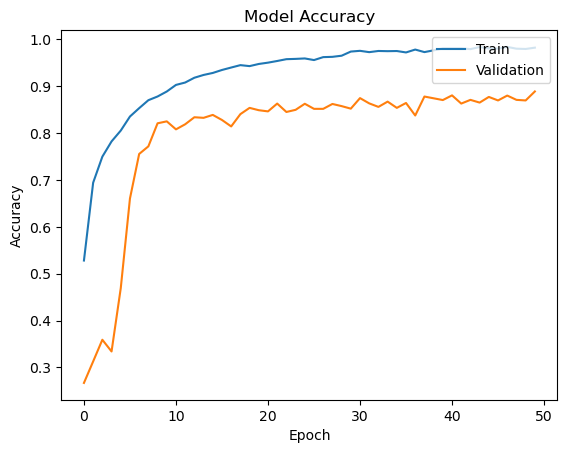

Final validation accuracy 0.8887500166893005
Maximal validation accuracy achieved over 50 epochs = 0.8887500166893005


In [103]:
model=final_model_eff()
history=model.fit(x=train_dataset_batch,epochs=50,verbose=1,validation_data=val_dataset_batch)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print(f"Final validation accuracy", history.history['val_accuracy'][-1])
print(f"Maximal validation accuracy achieved over 50 epochs =", np.max(history.history['val_accuracy']))

An even more powerful but less efficient architecture is given by parellising the network into two branches using the same structure of `final_model_eff`. The model is denoted by `final_model_acc` since it achieves out-of-sample performances between $89\%-91\%$ which is significantly better than `final_model_eff`. On the other side, however, it takes considerably longer to run. The model is given by:

In [152]:
def final_model_acc():
    input_data=tf.keras.Input(shape=(80, 80, 1))
    
    # First branch
    x = layers.Conv2D(32, (3,3), activation='relu')(input_data)
    x = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
        
    x = layers.Conv2D(32, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
        
    x = layers.Conv2D(32, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
        
    x = layers.Conv2D(32, (2,2), activation='relu')(x)
    x = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    
    # Second branch
    y = layers.Conv2D(64, (3,3), activation='relu')(input_data)
    y = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(y)
    y = layers.BatchNormalization()(y)
        
    y = layers.Conv2D(64, (3,3), activation='relu')(y)
    y = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(y)
    y = layers.BatchNormalization()(y)
        
    y = layers.Conv2D(64, (3,3), activation='relu')(y)
    y = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(y)
    y = layers.BatchNormalization()(y)
        
    y = layers.Conv2D(64, (2,2), activation='relu')(y)
    y = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.3)(y)
    y = layers.Flatten()(y)
    
    # Merging branch
    branch_concatenate=layers.Concatenate()([x,y])
    branch_concatenate=layers.Dense(128, activation="relu")(branch_concatenate)
    branch_concatenate=layers.Dense(64, activation="relu")(branch_concatenate)
    output=layers.Dense(8,activation='softmax')(branch_concatenate)
        
    # Compile model
    model = tf.keras.models.Model(input_data, output)
    #sgd = tf.keras.optimizers.SGD(5e-3)
    model.compile(optimizer="adam", loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
    return model

In [156]:
final_model_acc().summary()

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 conv2d_269 (Conv2D)            (None, 78, 78, 32)   320         ['input_45[0][0]']               
                                                                                                  
 conv2d_273 (Conv2D)            (None, 78, 78, 64)   640         ['input_45[0][0]']               
                                                                                                  
 max_pooling2d_222 (MaxPooling2  (None, 39, 39, 32)  0           ['conv2d_269[0][0]']             
 D)                                                                                        

                                                                                                  
 dense_130 (Dense)              (None, 8)            520         ['dense_129[0][0]']              
                                                                                                  
Total params: 320,936
Trainable params: 320,168
Non-trainable params: 768
__________________________________________________________________________________________________


Epoch 1/50
75/75 [==============================] - 36s 475ms/step - loss: 1.1619 - accuracy: 0.5781 - val_loss: 2.2362 - val_accuracy: 0.2438
Epoch 2/50
75/75 [==============================] - 37s 493ms/step - loss: 0.7301 - accuracy: 0.7383 - val_loss: 3.0282 - val_accuracy: 0.1725
Epoch 3/50
75/75 [==============================] - 37s 491ms/step - loss: 0.5474 - accuracy: 0.7992 - val_loss: 3.1945 - val_accuracy: 0.1917
Epoch 4/50
75/75 [==============================] - 39s 515ms/step - loss: 0.4308 - accuracy: 0.8431 - val_loss: 2.7887 - val_accuracy: 0.3346
Epoch 5/50
75/75 [==============================] - 37s 499ms/step - loss: 0.3361 - accuracy: 0.8759 - val_loss: 1.9567 - val_accuracy: 0.4625
Epoch 6/50
75/75 [==============================] - 37s 494ms/step - loss: 0.2642 - accuracy: 0.9066 - val_loss: 1.0784 - val_accuracy: 0.6604
Epoch 7/50
75/75 [==============================] - 36s 479ms/step - loss: 0.2189 - accuracy: 0.9231 - val_loss: 0.6627 - val_accuracy: 0.7817

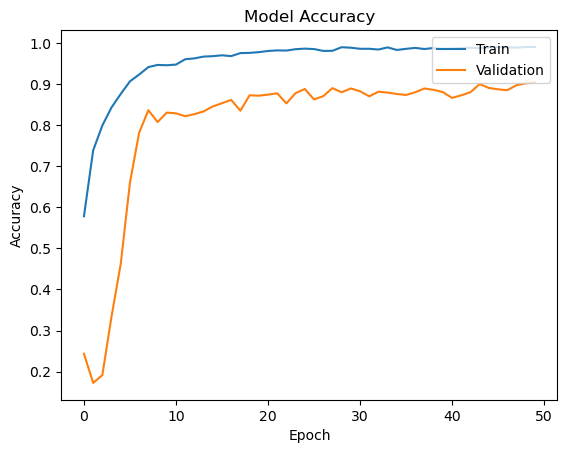

Final validation accuracy 0.9041666388511658
Maximal validation accuracy achieved over 50 epochs = 0.9041666388511658


In [153]:
model=final_model_acc()
history=model.fit(x=train_dataset_batch,epochs=50,verbose=1,validation_data=val_dataset_batch)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print(f"Final validation accuracy", history.history['val_accuracy'][-1])
print(f"Maximal validation accuracy achieved over 50 epochs =", np.max(history.history['val_accuracy']))

Note that even higher accuracies (up to $95\%$) could be achieved if the filter size of `layers.Conv2D()` was signifcantly increased but this comes at the cost of having to estimate millions of parameters and even less computationally efficient computations.

# Appendix

Inspiration was collected from popular deep learning reprisatiories towardsdatascience and github. The most useful source code is included in here:

In [ ]:
# sample code derived from https://towardsdatascience.com/music-genre-detection-with-deep-learning-cf89e4cb2ecc
# which refers to https://github.com/msaintfelix/TensorFlow_MusicGenre_Classifier

def design_model(input_shape):

    # Let's design the model architecture.
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(8, activation='softmax')
    ])
    model.compile(optimizer="adam", loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
    return model
# attains <84% in raw form